<a href="https://colab.research.google.com/github/rajindersingh041/Decision-tree/blob/main/Daily_NSE_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install NSEpy;pip install tabula-py;pip install stockstats; pip install ta;pip install yfinance

  Created wheel for NSEpy: filename=nsepy-0.8-py3-none-any.whl size=36085 sha256=678a5c4015100d4beacdf9ad80342bbd932c1ff40e47d99b0d5c39d84920a5f4
  Stored in directory: /root/.cache/pip/wheels/32/ab/d9/78ceea14cdf6de83376082b3cb0c2999fd77f823e35c47b9ec
Successfully built NSEpy
     |████████████████████████████████| 12.0 MB 3.7 MB/s 
  Created wheel for ta: filename=ta-0.8.0-py3-none-any.whl size=28895 sha256=c533c344175bcd00dca885406ec02039aaac4fc97d05a4f1aa130e5f9c916b26
  Stored in directory: /root/.cache/pip/wheels/7e/da/86/65cba22446ae2ef148de2079907264ef27feecfb7f51a45e0d
Successfully built ta
     |████████████████████████████████| 6.3 MB 6.1 MB/s 
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [2]:
from datetime import date, datetime, timedelta
from nsepy.history import get_price_list
import pandas as pd
import tabula
import re
import numpy as np
import copy
import os
import pickle
pd.set_option('display.max_columns', None)
import stockstats
import ta
import yfinance as yf


In [ ]:
# period_selected = 34
# for last day of month
# m_all = pd.date_range('2015-01-01', '2021-11-14', freq='BM').sort_values(ascending=False)
# m_all = pd.date_range('2020-01-01', periods=period_selected, freq='W-MON').sort_values(ascending=False)

In [ ]:
# period_selected = len(m_all)

In [ ]:
# for transforming pdf to pandas df
def pdf_to_table(fl_name):
  dfs = tabula.read_pdf(fl_name,pages='all',silent=True)
  df_c = pd.DataFrame()
  for i in dfs:
    for c in i.columns:
      if i[c].isna().sum()/i.shape[0] > .90:
        i = i.drop(c,axis=1)
    i_c_len = len(i.columns)
    i.columns = [str(x)+'_'+str(y) for x,y in  zip(['col']*i_c_len , range(0,i_c_len))]
    # print(i.head(2))
    df_c = pd.concat([df_c,i])
    df_c = df_c[~df_c['col_0'].isnull()]

  df_c.columns = ['Symbol','S_name','Industry','CP','MCap','Weight']
  return df_c

In [ ]:
# for reading zip file from url, opening zip file and extract cnx 200/ nifty 200 file
def get_zip_file(mmmyyyy):
  import requests, zipfile, io
  from re import match, findall

  check_file_status = [i for i in os.listdir() if (('NIFTY' in i.upper()) or ('CNX' in i.upper())) & (mmmyyyy in i)]

  if len(check_file_status)>0:
        print('get_zip_file --> read_file_from_local')
        return pdf_to_table(check_file_status[0])
  else:
    print('get_zip_file --> Not available in local')
    zip_file_url = "https://www1.nseindia.com/content/indices/indices_data{0}.zip".format(mmmyyyy)
    r = requests.get(zip_file_url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    # Replace substring in list of strings
    # print(z)

    filtered_values = list(filter(lambda v: findall('cnx200_{0}|cnx_200_{0}|nifty200_{0}|nifty_200_{0}'.format(mmmyyyy), v,re.IGNORECASE), z.namelist()))
    # print(filtered_values)
    val = filtered_values[0]
    z.extract(member=val)
    # z.extractall(members="NIFTY_50_May2021.pdf")
    return pdf_to_table(val)
  

In [ ]:
def m_0_7_13(bussiness_days_rng):

  final_df = pd.DataFrame()
  daily_close_price = read_daily_closing_all_stock_df()

  for i in bussiness_days_rng:

    all_stocks = daily_close_price[daily_close_price['TIMESTAMP'] == i]

    if (i.month >= 2) & (i.month <= 7):
      dt_to_pass = i.strftime('Feb%Y')
      check_file_status = [i for i in os.listdir() if (('NIFTY' in i.upper()) or ('CNX' in i.upper())) & (dt_to_pass in i)]
      
      if len(check_file_status)>0:
        print('read_file_from_local')
        nifty_50 = pdf_to_table(check_file_status[0])
      else:
        nifty_50 = get_zip_file(i.strftime('%Feb%Y'))
    else:
      dt_to_pass = i.strftime('Aug%Y')
      check_file_status = [i for i in os.listdir() if (('NIFTY' in i.upper()) or ('CNX' in i.upper())) & (dt_to_pass in i)]
      print(check_file_status)
      if len(check_file_status)>0:
        print('read_file_from_local')
        nifty_50 = pdf_to_table(check_file_status[0])
      else:
        nifty_50 = get_zip_file(i.strftime('%Aug%Y'))

      
    # try:
    #   dt_to_pass = i.strftime('%b%Y')
    #   check_file_status = [i for i in os.listdir() if (('NIFTY' in i.upper()) or ('CNX' in i.upper())) & (dt_to_pass in i)]
    #   if len(check_file_status)>0:
    #     print('read_file_from_local')
    #     nifty_50 = pdf_to_table(check_file_status[0])
    #   else:
    #     nifty_50 = get_zip_file(i.strftime('%b%Y'))
    # except:
    #   dt_to_pass = i.strftime('%b%Y')
    #   print(i,'get_zip_file not available')
    #   nifty_50 = get_zip_file((i+timedelta(days=3)).strftime('%b%Y'))
    #   print(i,'get_zip_file available now')
      
    final_stocks = all_stocks.merge(nifty_50,how="inner",left_on = 'SYMBOL',right_on = 'Symbol')
    if i == bussiness_days_rng[0]:
      final_stocks['TIMESTAMP_V2'] = 'm0'
    elif i == bussiness_days_rng[1]:
      final_stocks['TIMESTAMP_V2'] = 'm6'
    elif i == bussiness_days_rng[2]:
      final_stocks['TIMESTAMP_V2'] = 'm12'

      
    final_df = final_df.append(final_stocks)
    # print(final_df.shape)

  return final_df


In [ ]:
def for_return():
  start = date(2021,11, 13) # start = date(2015,1, 1)
  end = date(2021,11,18) # end = date(2021,11,13)
  all_days =pd.date_range(start, end, freq='D')
  appended_daily_df = pd.DataFrame()

  for i in all_days:
    try:
      daily_df = get_price_list(dt=i)[['TIMESTAMP','SYMBOL','CLOSE','PREVCLOSE']]
      # daily_df = daily_df.merge(stocks,how="inner",left_on='SYMBOL',right_on='Symbol')
      appended_daily_df = appended_daily_df.append(daily_df) 
      daily_df['return'] = daily_df['CLOSE']/daily_df['PREVCLOSE']  - 1
    except:
      # print('for_return not available')
      pass
  
  appended_daily_df['TIMESTAMP'] = pd.to_datetime(appended_daily_df['TIMESTAMP'])
  return appended_daily_df

In [ ]:
def read_daily_closing_all_stock_df():
  return pd.read_parquet('daily_closing_all_stocks.parquet', engine='pyarrow')

In [ ]:
appended_2015_21 = for_return()
# appended_2019['TIMESTAMP'].value_counts()

In [ ]:
# FOR SAVING THE DF
daily_closing_all_stocks = appended_2015_21.copy()
daily_closing_all_stocks.to_parquet('daily_closing_all_stocks.parquet', engine='pyarrow')

In [ ]:
# FOR READING THE DF
daily_closing_all_stocks = pd.read_parquet('daily_closing_all_stocks.parquet', engine='pyarrow')
all_stock_market_dates = (daily_closing_all_stocks['TIMESTAMP'].value_counts().reset_index())
dates = pd.Series(np.random.randint(100),index=pd.to_datetime(all_stock_market_dates['index'].values))

In [ ]:
# daily_closing_all_stocks = daily_closing_all_stocks.append(appended_2015_21)
# daily_closing_all_stocks.to_parquet('daily_closing_all_stocks.parquet', engine='pyarrow')


In [ ]:
last_trading_date_of_month = pd.DataFrame(dates.groupby(dates.index.to_period('M')).apply(lambda x: x.index.max())).reset_index(drop=True)
last_trading_date_of_month.columns = ['dates']

In [ ]:
m_all = pd.to_datetime(last_trading_date_of_month['dates'].values)
m_all = m_all.sort_values(ascending=False)

In [ ]:
# for i in range(0,2):
#   print(daily_closing_all_stocks[daily_closing_all_stocks['TIMESTAMP'] == m_all[i]].head(2))

In [ ]:
# daily_closing_all_stocks[daily_closing_all_stocks['SYMBOL'] == 'RELIANCE'].to_csv('reliance.csv',index=False)

In [ ]:
appended_daily_df = pd.read_parquet('daily_closing_all_stocks.parquet')

super_set_20 = pd.DataFrame();super_set_40 = pd.DataFrame();super_set_200 = pd.DataFrame()
dict_of_top_15 = {}
dict_of_top_200 = {}

m_month_name = m_all.strftime('%d%b%Y')

for i in range(0,1):
  print(i)
  # for months
  da = [m_all[i],m_all[i+6],m_all[i+12]]#2021-03-28

  # for weeks
  # da = [m_all[i],m_all[i+26],m_all[i+52]]#2021-03-28

  # final_df = m_0_7_13(da)

  final_df = appended_daily_df[appended_daily_df['TIMESTAMP'].isin(da)].copy()

  final_df['TIMESTAMP_V2'] = np.select(
    [
        final_df['TIMESTAMP'] == da[0], 
        final_df['TIMESTAMP'] == da[1], 
        final_df['TIMESTAMP'] == da[2]
    ], 
    [
        'm0', 
        'm6',
     'm12'
    ], 
    default='Unknown')

  
  if (da[0].month >= 2) & (da[0].month <= 7):
    stocks = get_zip_file(da[0].strftime('Feb%Y'))
  else:
    stocks = get_zip_file(da[0].strftime('Aug%Y'))

  appended_daily_df = appended_daily_df.merge(stocks,how="inner",left_on='SYMBOL',right_on='Symbol')

  last_12m = appended_daily_df[(pd.to_datetime(appended_daily_df['TIMESTAMP']).dt.date >= da[2]) 
                                & 
                              (pd.to_datetime(appended_daily_df['TIMESTAMP']).dt.date <= da[0])].copy()

  last_6m = appended_daily_df[(pd.to_datetime(appended_daily_df['TIMESTAMP']).dt.date >= da[1]) 
                              & 
                              (pd.to_datetime(appended_daily_df['TIMESTAMP']).dt.date <= da[0])].copy()

  def find_annual_std_dev_returns(df_passed):
    # df_passed['Log_CLOSE'] = np.log(df_passed['CLOSE'])
    # df_passed['Log_PREVCLOSE'] = np.log(df_passed['PREVCLOSE'])
    df_passed['Log_return'] = np.log(df_passed['CLOSE']/df_passed['PREVCLOSE'])
    # df_passed['Log_return'] = df_passed['Log_CLOSE']/df_passed['Log_PREVCLOSE']  - 1
    df_passed = df_passed.groupby('SYMBOL').agg({'Log_return':np.std}).reset_index()
    df_passed.columns = ['SYMBOL','log_stdev_return']
    df_passed['log_stdev_return_annual'] = df_passed['log_stdev_return'] * np.sqrt(250)
    return df_passed

  last_12m = find_annual_std_dev_returns(last_12m)
  last_6m = find_annual_std_dev_returns(last_6m)

  # final_df = 
  returns = final_df.pivot_table(values='CLOSE',index='SYMBOL',columns = 'TIMESTAMP_V2').reset_index()
  returns['12m'] = returns['m0']/returns['m12']-1
  returns['6m'] = returns['m0']/returns['m6']-1

  end_df = returns.merge(last_12m,how='inner')
  end_df = end_df.rename(columns={'log_stdev_return_annual':'log_stdev_return_annual_12m',
                                  'log_stdev_return':'log_stdev_return_12m'})

  final_end_df = end_df.merge(last_6m,how='inner')
  final_end_df = final_end_df.rename(columns={'log_stdev_return_annual':'log_stdev_return_annual_6m',
                                  'log_stdev_return':'log_stdev_return_6m'})

  final_end_df['mr12'] = final_end_df['12m']/final_end_df['log_stdev_return_annual_12m']
  final_end_df['mr6'] = final_end_df['6m']/final_end_df['log_stdev_return_annual_6m']

  mr12_std, mr12_mean = np.std(final_end_df['mr12']), np.mean(final_end_df['mr12'])
  mr6_std, mr6_mean = np.std(final_end_df['mr6']), np.mean(final_end_df['mr6'])

  final_end_df['mr12_z'] = (final_end_df['mr12'] - mr12_mean)/mr12_std
  final_end_df['mr6_z'] = (final_end_df['mr6'] - mr6_mean)/mr6_std

  final_end_df['combined_mr_score'] =( 0.5*final_end_df['mr12_z'] )+ (0.5*final_end_df['mr6_z'])
  final_end_df['combined_mr_score_normalized'] = np.where(final_end_df['combined_mr_score']>=0,1+final_end_df['combined_mr_score'],
          1/(1-final_end_df['combined_mr_score']))

  df_anal = final_end_df.sort_values('combined_mr_score_normalized',ascending=False)
  df = df_anal.merge(stocks,how='inner',left_on='SYMBOL',right_on = 'Symbol')

  # mom30.dtypes
  mom30 = df.head(200).copy()
  mom30['MCap'] = pd.to_numeric(mom30['MCap'], errors='coerce')
  mom30['Weight'] = pd.to_numeric(mom30['Weight'], errors='coerce')
  mom30['MCap_into_Weight'] =  mom30['combined_mr_score_normalized'] * mom30['MCap']
  # mom30['mom30_weight_pct'] = (mom30['mom30_weight']/mom30['mom30_weight'].sum())*100
  # mom30['index_weight_5times'] = mom30['Weight'] * 5
  # mom30['final_weight'] = mom30[['index_weight_5times','mom30_weight_pct']].min(axis=1)
  mom30['rank'] = mom30['combined_mr_score_normalized'].rank(ascending=False)

  top_20 = mom30.sort_values('rank',ascending=True).head(20); top_20['as_of'] = da[0]
  top_40 = mom30.sort_values('rank',ascending=True).head(40); top_40['as_of'] = da[0]
  top_200 = mom30.sort_values('rank',ascending=True).head(200); top_200['as_of'] = da[0]
  top_15 = mom30.sort_values('rank',ascending=True).head(15); top_200['as_of'] = da[0]



  keyname = 'df_'+ str(i)#str(m_month_name[i])
  dict_of_top_15[keyname] = copy.deepcopy(top_15)
  dict_of_top_200[keyname] = copy.deepcopy(top_200)

  super_set_20 = super_set_20.append(top_20)
  super_set_40 = super_set_40.append(top_40)
  super_set_200 = super_set_200.append(top_200)

  # print(super_set_20.shape,super_set_40.shape,super_set_200.shape)
  

0
get_zip_file --> read_file_from_local


In [ ]:
# a_file = open("dict_of_top_200_47_months_updated_std_vola.pkl", "wb")
# pickle.dump(dict_of_top_200, a_file)
# a_file.close()

# a_file = open("dict_of_top_200_weekly.pkl", "wb")
# pickle.dump(dict_of_top_200, a_file)
# a_file.close()


# a_file = open("dict_of_top_200_weekly.pkl", "rb")
# output = pickle.load(a_file)

a_file2 = open("dict_of_top_200_47_months.pkl", "rb")
dict_of_top_200 = pickle.load(a_file2)


In [ ]:
# c1 = output2['df_0']
# c1['w'] = c1['Weight'] * c1['combined_mr_score_normalized']
# c1['CP'] = pd.to_numeric(c1['CP'])
# c11 = c1[c1['rank'] <=30].sort_values('rank')[['rank','SYMBOL','CP','combined_mr_score_normalized','MCap','Weight','w']]

# c11['5t_Weight'] = c11['Weight'] * 5
# c11['f_w']=c11[['w','5t_Weight']].min(axis=1)
# c11['max_w'] = 5

# c11['final_weight_cap'] = c11[['max_w','f_w']].min(axis=1)
# c11['final_weight_cap_pct'] = c11['final_weight_cap']/c11['final_weight_cap'].sum()
# c11['money_invested'] = 136782.75 * c11['final_weight_cap_pct']
# c11['share_bought'] = c11['money_invested']/pd.to_numeric(c11['CP'])

In [ ]:
# # d1[(d1['rank'] >= 0) & (d1['rank'] <= 30)]
# d1['MCap_into_Weight'] = d1['MCap'] * d1['Weight']
# d1['MCap_into_Weight_Share'] = d1['MCap_into_Weight'] / d1['MCap_into_Weight'].sum()
# d1['MCap_into_Weight_Share_5t'] = (5 * d1['MCap_into_Weight']) / d1['MCap_into_Weight'].sum()
# d1['5pct_cap'] = 0.05

# d1['weight_found'] = d1[['MCap_into_Weight_Share_5t','5pct_cap']].min(axis=1)


# d2 = d1[(d1['rank'] >= 0) & (d1['rank'] <= 30)].copy()
# # d2['MCap_into_Weight_Share'] = d2['MCap_into_Weight'] / d2['MCap_into_Weight'].sum()
# # d2['MCap_into_Weight_Share_5t'] = d2['MCap_into_Weight_Share'] * 5
# # d2['MCap_Share'] = (d2['MCap']) / d2['MCap'].sum()
# # d2['MCap_into_Weight_Share_5t'] = d2['MCap_into_Weight_Share'] * 5
# # d2['5pct_cap'] = 0.05

# d2['final_weight_found'] = d2['weight_found']/ d2['weight_found'].sum()
# #d2[['MCap_into_Weight_Share','Weight_5t','5pct_cap']].min(axis=1)

In [ ]:
# super_set_40[pd.to_numeric(super_set_40['CP']) < 2000][:10]

In [ ]:
# dict_of_top_200['df_6'].sort_values('rank').head(20)

In [ ]:
def rebalance_portfolio(df,sold_stocks,new_stocks):
  df.loc[df['SYMBOL'].isin(sold_stocks) , 'updated_investment'] = -1*(df['CP'] * df['no_of_stock_buy'])
  df.loc[df['SYMBOL'].isin(new_stocks) , 'updated_investment'] = 1(df['CP'] * df['no_of_stock_buy'])
  # df['updated_investment'] = 



In [ ]:
def equal_Weight_stocks(df):
  ews_df = df.copy()

  n_stocks = ews_df.shape[0] #number of stocks qualify
  df_max_price_of_selected_Stocks = ews_df['CP'].max()
  pred_money_to_invest = df_max_price_of_selected_Stocks * n_stocks

  ews_df['no_of_stock_buy'] = round(df_max_price_of_selected_Stocks/ews_df['CP'],0) # rounded to make them whole numbers
  ews_df['investment_per_stock'] = ews_df['no_of_stock_buy'] * ews_df['CP']

  # print(ews_df.tail(4))
  return ews_df

In [ ]:
def update_buy_stocks(df):
  # buy stocks saved in dict
  buy_dict = dict(zip(df['SYMBOL'],zip(df['CP'],buy_1['no_of_stock_buy'])))
  buy_stocks = list(buy_dict.keys())


In [ ]:
appended_daily_df = pd.read_parquet('daily_closing_all_stocks.parquet')

In [ ]:
# dict_of_top_200 = output2
buy_dict = dict()
sell_dict = dict()
new_prospect = dict()
hold_dict = dict()
main_call = dict()
buy_3 = pd.DataFrame()
for i in range(0,-1,-1):
  total_gain = 0 

  # last month in data
  df_read = dict_of_top_200['df_{}'.format(i)]
  df_read['CP'] = pd.to_numeric(df_read['m0'])# df_read['CP'] = pd.to_numeric(df_read['CP'])
  
  # buy these stocks
  # buy_1 = df_read[(df_read['rank'] > 0) & (df_read['rank'] <= 20) & (df_read['CP'] <=5000)].copy()#
  buy_1 = df_read[(df_read['CP'] <=2500)].copy()
  buy_1 = equal_Weight_stocks(buy_1)
  buy_1 = buy_1.sort_values('rank')
  buy_1 = buy_1.head(10) # top 20 stocks
  print(buy_1[['SYMBOL','m0','m6','m12','no_of_stock_buy' , 'investment_per_stock']])

  print('Money_Invested',round(buy_1['investment_per_stock'].sum(),0))
  month_name = buy_1['as_of'].max().strftime('%b%Y')

  #check sell of bought stocks in following months
  for j in range(i-1,0,-1):
    
    # load next month data
    i_df = dict_of_top_200['df_{}'.format(j)]
    i_df['CP'] = pd.to_numeric(i_df['m0'])# i_df['CP'] = pd.to_numeric(i_df['CP'])

    month_name = i_df['as_of'].max().strftime('%b%Y')


    # check if any stock from last month moved to rank > 40
    buy_dict = dict(zip(buy_1['SYMBOL'],zip(buy_1['CP'],buy_1['no_of_stock_buy'])))
    print(buy_dict)
    buy_stocks = list(buy_dict.keys())

    stock_sold = i_df[(i_df['Symbol'].isin(buy_stocks)) & (i_df['rank'] > 40)][['SYMBOL','CP','as_of']]
    stock_sold.columns = ['SYMBOL','SOLD_CP','as_of']
    
    # find price at which at which stock was bought [buy_1 store CP value]
    buy_price_of_stock_sold = stock_sold.merge(buy_1[['SYMBOL','CP','no_of_stock_buy']],how='inner')
    
    #capital gain is calculated based on number of stocks invested in
    buy_price_of_stock_sold['captial_gain'] = (buy_price_of_stock_sold['SOLD_CP'] - buy_price_of_stock_sold['CP'])*buy_price_of_stock_sold['no_of_stock_buy']
    buy_price_of_stock_sold['value_withdrawn'] = buy_price_of_stock_sold['SOLD_CP'] * buy_price_of_stock_sold['no_of_stock_buy']
    

    #save sold stocks in another dic
    sell_dict = dict(zip(buy_price_of_stock_sold['SYMBOL'],zip(buy_price_of_stock_sold['CP'],buy_price_of_stock_sold['no_of_stock_buy'])))
    print(month_name,'sell',list(sell_dict.keys()))

    #total gain from selling these stocks
    total_gain = total_gain + buy_price_of_stock_sold['captial_gain'].sum()
  
    #position now open to fill
    no_of_stocks_sold = buy_price_of_stock_sold.shape[0] # position available to fill
    
    #check new prospects which was not in initial buy list and rank < 10
    buy_dict = dict(zip(buy_1['SYMBOL'],zip(buy_1['CP'],buy_1['no_of_stock_buy'])))
    buy_stocks = list(buy_dict.keys())

    # print('buy stocks-->',buy_stocks)
    new_stock_prospects = i_df[(~i_df['SYMBOL'].isin(buy_stocks)) & (i_df['rank'] <= 10) & (i_df['CP'] < 5000)].sort_values('rank').head(no_of_stocks_sold)
    # print(new_stock_prospects[['SYMBOL','CP']])
    #new stocks also saved in the list
    new_prospect = dict(zip(new_stock_prospects['SYMBOL'],new_stock_prospects['CP']))
    print(month_name,'new',list(new_prospect.keys()))

    #CHECK CAPITAL GAINS FOR BUY_1 as per next month
    
    # temp = i_df[['SYMBOL','CP','as_of']]
    # temp.columns = ['SYMBOL','LATEST_CP','LATEST_AS_OF']
    # cg_df = buy_1[['SYMBOL','CP','as_of','no_of_stock_buy']].merge(temp, how = 'inner')
    # cg_df['C_GAIN'] = (cg_df['LATEST_CP'] - cg_df['CP']) * cg_df['no_of_stock_buy']

    # print(cg_df['LATEST_AS_OF'].max().strftime('%b%Y'),round(cg_df['C_GAIN'].sum(),0))
    # print('top gainers',cg_df.sort_values('C_GAIN',ascending=False)[['SYMBOL','C_GAIN']].head(3))
    # print('top losers',cg_df.sort_values('C_GAIN',ascending=True)[['SYMBOL','C_GAIN']].head(3))

    #update stocks list now
    
    
    #initial buy
    d1 = buy_1[['SYMBOL','CP','no_of_stock_buy','investment_per_stock','as_of']].copy()
    d1= d1.rename(columns={'CP':'INITIAL_CP','no_of_stock_buy':'INITIAL_no_of_stock_buy','investment_per_stock':'INITIAL_investment_per_stock','as_of':'INITIAL_as_of'})
    # temp_df = i_df[['SYMBOL','CP']]; temp_df = temp_df.rename(columns={'CP','NEW_CP'})

    d1 = d1.merge(i_df[['SYMBOL','CP','as_of']].rename(columns={'CP':'NEW_CP'}),how = 'left')
    d1['return'] = (d1['NEW_CP'] / d1['INITIAL_CP']) - 1
    d1['value_now'] = (1+d1['return']) * d1['INITIAL_investment_per_stock']
    d1[['INITIAL_as_of','as_of']] = d1[['INITIAL_as_of','as_of']].apply(pd.to_datetime) #if conversion required
    d1['hold_period'] = (d1['as_of'] - d1['INITIAL_as_of'])/np.timedelta64(1, 'M')
    d1['hold_period'] = d1['hold_period'].astype(int)
    

    
    print('return ----->',d1['value_now'].sum()/d1['INITIAL_investment_per_stock'].sum() - 1)
    print(d1[['SYMBOL','INITIAL_CP','NEW_CP','hold_period']])
    # print('Money value now -->',(d1['value_now']).sum())


    #remove stocks sold
    buy_1 = buy_1[~buy_1['SYMBOL'].isin(stock_sold['SYMBOL'].values)]
    
    
    #add new stocks
    buy_1 = buy_1.append(new_stock_prospects)

    # print(buy_1)

    # print(buy_1[['SYMBOL','no_of_stock_buy']])
    # print(d1[['SYMBOL','old_no_of_stock_buy']])

    # print(buy_1.columns)
    buy_1 = equal_Weight_stocks(buy_1).copy() # buy_2 = .............
    
    # buy_2 = (buy_2.merge(d1,how='left')[['SYMBOL','CP' ,'NEW_CP', 'no_of_stock_buy', 'investment_per_stock', 'INITIAL_CP','INITIAL_no_of_stock_buy', 'INITIAL_investment_per_stock','INITIAL_as_of']])
    # print(buy_1[['SYMBOL','no_of_stock_buy','investment_per_stock']])
    # print(buy_2)
    
    # print(buy_2.columns)
    # buy_2.loc[buy_2['INITIAL_no_of_stock_buy'] > 0, 'final_rebalance_n_stocks'] = buy_2['INITIAL_no_of_stock_buy']
    # buy_2.loc[buy_2['INITIAL_no_of_stock_buy'] > 0, 'final_rebalance_investment'] = buy_2['final_rebalance_n_stocks'] * buy_2['CP']
    # buy_2.loc[buy_2['INITIAL_no_of_stock_buy'].isna() , 'final_rebalance_n_stocks'] = buy_2['no_of_stock_buy']
    # buy_2.loc[buy_2['INITIAL_no_of_stock_buy'].isna(), 'final_rebalance_investment'] = buy_2['final_rebalance_n_stocks'] * buy_2['CP']
    # buy_2['final_rebalance_weight'] = buy_2['final_rebalance_investment']/buy_2['final_rebalance_investment'].sum()

    # buy_2['rebalanced_weight'] = buy_2['investment_per_stock']/buy_2['investment_per_stock'].sum()

    # print('Money invested after rebalance', buy_2['investment_per_stock'].sum())
    # print(buy_2[['SYMBOL','CP','NEW_CP','final_rebalance_n_stocks','final_rebalance_investment']].rename(columns = {'final_rebalance_n_stocks':'n','final_rebalance_investment':'amt'}))
    
    # buy_2['no_of_stock_buy'] =   buy_2['final_rebalance_n_stocks']
    # print('New--->',buy_2)
    # buy_1 = buy_2.copy()
    buy_3 = buy_3.append(buy_1)
    
    # print(buy_2[['SYMBOL','no_of_stock_buy']])
    # buy_1 = buy_1.merge(buy_2[['SYMBOL','no_of_stock_buy']].rename(columns={'no_of_stock_buy':'new_no_of_stock_buy'}),how='left')
    # buy_1['old_no_of_stock_buy'] = buy_1['no_of_stock_buy']
    # buy_1['no_of_stock_buy'] = buy_1['new_no_of_stock_buy']


    # print('Final',buy_1)
    
    #value of sold stocks
    # print('Sold_value',round(buy_price_of_stock_sold['value_withdrawn'].sum(),0))

    # hold_stocks = i_df[(i_df['Symbol'].isin(buy_stocks))][['SYMBOL','CP','as_of']]
    # hold_stocks = hold_stocks.merge(buy_1[['SYMBOL','no_of_stock_buy']],how='left')
    # hold_stocks['new_value'] = hold_stocks['CP'] * hold_stocks['no_of_stock_buy']
    # print('Return of stocks not sold', )
  
  # print(buy_1)
  # number_of_stocks = buy_1.shape[0] #number of stocks qualify
  # max_cp_of_selected_stocks = buy_1['CP'].max()
  # pred_money_investment = max_cp_of_selected_stocks * number_of_stocks
  

  # buy_1['no_of_stock_buy'] = round(max_cp_of_selected_stocks/buy_1['CP'],0) # rounded to make them whole numbers
  # buy_1['investment_per_stock'] = buy_1['no_of_stock_buy'] * buy_1['CP']

      # # buy stocks saved in dict
  # buy_dict = dict(zip(buy_1['SYMBOL'],zip(buy_1['CP'],buy_1['no_of_stock_buy'])))
  # buy_stocks = list(buy_dict.keys())
  
  # print(buy_dict)
  # buy_sell_calls_made['Buy'] = dict(zip(buy_1['SYMBOL'],zip(buy_1['CP'],buy_1['no_of_stock_buy'])))
  
  # calls_made_in_month[month_name] = buy_sell_calls_made

  
  # buy_1 = buy_1.sort_values('Symbol')
  # print(calls_made_in_month)
  # print(buy_sell_calls_made)
  

  # print(df_read['as_of'].max().strftime('%b%Y'),'\n')
  # print('Stocks bought on -->',buy_stocks)
  # print('Stocks bought on -->',buy_1['CP'].values)
  # print('Money to invest --->',int(buy_1['CP'].max() * (buy_1['CP'].shape[0])))
  # m = int(buy_1['CP'].max() * (buy_1['CP'].shape[0]))
  # print('No. of Stocks---->', [round(m/(i*buy_1.shape[0]),0) for i in list(buy_1['CP'].values)])
  
  # stock_buy_cp = list(buy_1['CP'].values)
  # n_stock_buy = [round(m/(i*buy_1.shape[0]),0) for i in list(buy_1['CP'].values)]

  # m = round(sum([a*b for a,b in zip(stock_buy_cp,n_stock_buy)]),0)
  # print('Money to invest --->',m)
  # # buy_call['df_{}'.format(i)]['Stock']
  # # print(buy_1[['Symbol','CP','rank']].head(2))



    # print(buy_1['SYMBOL'].values)
    #incremental changes done in quantity

    
    # d2 = buy_2[['SYMBOL','no_of_stock_buy']]; d2 = d2.rename(columns = {'no_of_stock_buy':'updated_no_of_stock_buy'})
    # d4 = new_stock_prospects[['SYMBOL','CP']]; d4['no_new_stock_buy'] = 0
    # d5 = d1.merge(d2,how='left')
    # d6 = d5.merge(d4,how='left')

    # print(d6)

    #minimal money required to 


    #print(new_stock_prospects)
    
    # print(buy_sell_calls_made)
    # buy_sell_calls_made['Sell'] = dict(zip(buy_price_of_stock_sold['SYMBOL'],zip(buy_price_of_stock_sold['CP'],buy_price_of_stock_sold['no_of_stock_buy'])))
    
    
    # calls_made_in_month[month_name] = buy_sell_calls_made['Sell']#dict(zip(buy_price_of_stock_sold['SYMBOL'],zip(buy_price_of_stock_sold['CP'],buy_price_of_stock_sold['no_of_stock_buy'])))

    # print(calls_made_in_month)

    # stock_sold = list(buy_price_of_stock_sold['SYMBOL'].values)
    # if buy_price_of_stock_sold.shape[0]>0:
    #   print(buy_price_of_stock_sold['as_of'].max().strftime('%b%Y'),'Stock sold -->',buy_price_of_stock_sold['SYMBOL'].values,int(buy_price_of_stock_sold['captial_gain'].sum()))
    #   # print(buy_price_of_stock_sold)
    # else:
    #   print(i_df['as_of'].max().strftime('%b%Y'),'No Stock sold')
    
    # if i_df[(~i_df['SYMBOL'].isin(buy_stocks)) & (i_df['rank'] <= 5)].shape[0] >0:
    #   print(i_df[(~i_df['SYMBOL'].isin(buy_stocks)) & (i_df['rank'] <= 5)]['as_of'].max().strftime('%b%Y'), 'New stocks added--->',i_df[(~i_df['SYMBOL'].isin(buy_stocks)) & (i_df['rank'] <= 10)]['SYMBOL'].values)

    # buy_stocks = [x for x in buy_stocks if x not in stock_sold]

  # information of stocks which have been held it date are
  # buy_price_of_left_stocks = buy_1[buy_1['Symbol'].isin(buy_stocks)][['SYMBOL','CP','no_of_stock_buy']]
  # buy_price_of_left_stocks.columns = ['SYMBOL','BUY_CP','no_of_stock_buy']
  # latest_data_of_stocks = dict_of_top_200['df_1']
  # captial_gain_of_holdings = buy_price_of_left_stocks.merge(latest_data_of_stocks[['SYMBOL','CP','no_of_stock_buy']],how='inner')
  # captial_gain_of_holdings['CP']= pd.to_numeric(captial_gain_of_holdings['CP'])
  # captial_gain_of_holdings['captial_gain'] = (captial_gain_of_holdings['CP'] - captial_gain_of_holdings['BUY_CP'])*captial_gain_of_holdings['no_of_stock_buy']
  # # print('Stock holded-->',captial_gain_of_holdings['SYMBOL'].values)
  # print(i, 'Released CG-->',int(total_gain) , 'UnReleased CG-->', int(captial_gain_of_holdings['captial_gain'].sum()))
  # print('\n')
  # 'SYMBOL'
  # 'INITIAL_CP'
  # 'INITIAL_no_of_stock_buy'
  

        SYMBOL       m0       m6      m12  no_of_stock_buy  \
3    TATAPOWER   237.10   106.45    64.90             11.0   
5      POLYCAB  2494.05  1674.25   958.40              1.0   
6     ADANIENT  1688.75  1316.30   398.40              1.0   
10       TITAN  2478.20  1596.25  1361.20              1.0   
12         OIL   213.00   132.50    96.15             12.0   
14       TECHM  1567.75  1021.65   876.85              2.0   
15  TATAMOTORS   509.70   318.75   180.35              5.0   
17        INFY  1779.40  1393.75  1100.00              1.0   
18  MCDOWELL-N   920.05   612.45   548.40              3.0   
19      GRASIM  1774.50  1471.20   875.75              1.0   

    investment_per_stock  
3                2608.10  
5                2494.05  
6                1688.75  
10               2478.20  
12               2556.00  
14               3135.50  
15               2548.50  
17               1779.40  
18               2760.15  
19               1774.50  
Money_Invested 23823

In [ ]:
dic

In [ ]:
buy_3.to_csv('abc.csv')

In [ ]:

t = dict_of_top_200['df_39']


In [ ]:
# t[t['SYMBOL'] == 'ADANITRANS']
t.shape

(149, 25)

In [ ]:
# buy_1[['SYMBOL','m0','CP']]
# buy_1
# buy_1[['SYMBOL','CP']].merge(output2['df_1'][['SYMBOL','CP']], how = 'inner')
latest_trend = output2['df_1'][['SYMBOL','CP']]
latest_trend.columns = ['SYMBOL','LATEST_CP']

buy_1[['SYMBOL','CP']].merge(latest_trend[['SYMBOL','LATEST_CP']], how = 'inner')

,SYMBOL,CP,LATEST_CP
0,MINDTREE,1417.30,4492.40
1,APOLLOHOSP,2347.90,4262.05
2,INFY,1100.00,1667.75
3,TATASTEEL,577.35,1315.95
4,DIVISLAB,3841.90,5150.15
5,LTI,3659.50,6682.30
6,LTI,3963.90,6682.30
7,NAUKRI,4757.90,6075.35
8,HAVELLS,1044.75,1262.95
9,ADANITRANS,908.40,1767.40


In [ ]:
p = [554.65, 1580.75, 2361.75, 4669.5,4914.1]
s = sum(p)


# while((((((1/len(p))*s)/p[0]) < 1) & ((((1/len(p))*s)/p[1]) < 1) & ((((1/len(p))*s)/p[2]) < 1) & ((((1/len(p))*s)/p[3]) < 1) & ((((1/len(p))*s)/p[4]) < 1))):
#       s = s*1.10
#       print(s)

In [ ]:
[s/ (x*5) for x in p],s

([5.0773460741007845,
  1.7815277558121145,
  1.1923997036096114,
  0.6030945497376593,
  0.5730754359903136],
 14080.75)

In [ ]:
from scipy.optimize import linprog


# Set up values relating to both minimum and maximum values of y
coefficients_inequalities = [[554.65, 1580.75, 2361.75, 4669.5,4914.1]]  # require -1*x + -1*y <= -180
constants_inequalities = [-180]
coefficients_equalities = [[3, 12]]  # require 3*x + 12*y = 1000
constants_equalities = [1000]
bounds_x = (30, 160)  # require 30 <= x <= 160
bounds_y = (10, 60)  # require 10 <= y <= 60


In [ ]:
df_stock = appended_daily_df[(appended_daily_df['SYMBOL'] == 'JSWENERGY') & (pd.to_datetime(appended_daily_df['TIMESTAMP'])>=m_all[17])
&  (pd.to_datetime(appended_daily_df['TIMESTAMP'])<=m_all[0])].reset_index()

returns = df_stock['CLOSE'].pct_change(1).copy()

ret_index = 100*(1 + returns).cumprod()

ret_index[0] = 100 # Set first value to 1



In [ ]:
ret_index

0     100.000000
1     105.891927
2     109.212240
3     113.509115
4     109.570313
5     110.123698
6     107.486979
7     108.789062
8     108.789062
9     109.244792
10    111.295573
11    109.440104
12    112.792969
13    122.981771
14    126.334635
15    127.929687
16    131.217448
17    141.438802
18    156.738281
19    156.933594
20    164.453125
21    165.006510
Name: CLOSE, dtype: float64

In [ ]:
(2285.95 - 2155.20)/2155.20

0.060667223459539725

In [ ]:
df_stock

,index,TIMESTAMP,SYMBOL,CLOSE,PREVCLOSE
0,564768,28-JUN-2021,PIDILITIND,2155.20,2134.25
1,566256,29-JUN-2021,PIDILITIND,2161.75,2155.20
2,567745,30-JUN-2021,PIDILITIND,2153.95,2161.75
3,569225,01-JUL-2021,PIDILITIND,2169.15,2153.95
4,570702,02-JUL-2021,PIDILITIND,2178.85,2169.15
...,...,...,...,...,...
77,682595,19-OCT-2021,PIDILITIND,2470.85,2501.80
78,684286,20-OCT-2021,PIDILITIND,2417.50,2470.85
79,685968,21-OCT-2021,PIDILITIND,2305.50,2417.50
80,687640,22-OCT-2021,PIDILITIND,2316.40,2305.50


In [ ]:
buy_sell = dict()
dict_of_top_200 = output

for i in range(0,20):

  #last month dataset
  df_last_month = dict_of_top_200['df_{0}'.format(i+1)]
  # print(df_last_month.dtypes)
  df_last_month['CP'] = pd.to_numeric(df_last_month['CP'], errors='coerce')
    # mom30['MCap'] = pd.to_numeric(mom30['MCap'], errors='coerce')

  df_last_month_top_30 = df_last_month[(df_last_month['rank'] > 0) & (df_last_month['rank'] <= 30) & (df_last_month['CP'] <=2500) ]

  buy_sell['df_{0}'.format(i)] = dict()
  
  buy_sell['df_{0}'.format(i)]['Buy'] =  pd.Series(df_last_month_top_30.CP.values,index=df_last_month_top_30.Symbol).to_dict()

  #current month
  df_curr_month = dict_of_top_200['df_{0}'.format(i)][['SYMBOL','rank','CP']]
  # print(df_curr_month)
  df_curr_month.columns = ['SYMBOL','next_month_rank','next_month_CP']
  
  #get current month ranks in last month dataset
  df_last_month_top_30 = df_last_month_top_30.merge(df_curr_month,how="left")

  buy_sell['df_{0}'.format(i)]['Sell'] =  pd.Series(df_last_month_top_30[(df_last_month_top_30['next_month_rank'] >= 50)
                                             | (df_last_month_top_30['next_month_rank'].isnull()) ]['CP'].values,index=df_last_month_top_30[(df_last_month_top_30['next_month_rank'] >= 50)
                                             | (df_last_month_top_30['next_month_rank'].isnull()) ]['SYMBOL'].values).to_dict()



In [ ]:
buy_sell = dict()
dict_of_top_200 = output

for i in range(0,20):

  #last month dataset
  df_last_month = dict_of_top_200['df_{0}'.format(i+1)]
  # print(df_last_month.dtypes)
  df_last_month['CP'] = pd.to_numeric(df_last_month['CP'], errors='coerce')
    # mom30['MCap'] = pd.to_numeric(mom30['MCap'], errors='coerce')

  df_last_month_top_30 = df_last_month[(df_last_month['rank'] > 0) & (df_last_month['rank'] <= 30) & (df_last_month['CP'] <=2500) ]

  buy_sell['df_{0}'.format(i)] = dict()
  
  buy_sell['df_{0}'.format(i)]['Buy'] =  pd.Series(df_last_month_top_30.CP.values,index=df_last_month_top_30.Symbol).to_dict()

  #current month
  df_curr_month = dict_of_top_200['df_{0}'.format(i)][['SYMBOL','rank','CP']]
  # print(df_curr_month)
  df_curr_month.columns = ['SYMBOL','next_month_rank','next_month_CP']
  
  #get current month ranks in last month dataset
  df_last_month_top_30 = df_last_month_top_30.merge(df_curr_month,how="left")

  buy_sell['df_{0}'.format(i)]['Sell'] =  pd.Series(df_last_month_top_30[(df_last_month_top_30['next_month_rank'] >= 50)
                                             | (df_last_month_top_30['next_month_rank'].isnull()) ]['CP'].values,index=df_last_month_top_30[(df_last_month_top_30['next_month_rank'] >= 50)
                                             | (df_last_month_top_30['next_month_rank'].isnull()) ]['SYMBOL'].values).to_dict()



In [ ]:
for i in range(len(buy_sell.keys())-1,0,-1):
  # print(i)
  if i == 19:
    print(m_all[i],i,'Buy',buy_sell['df_{}'.format(i)]['Buy'])
  print(m_all[i],i,'Sell',buy_sell['df_{}'.format(i)]['Sell'])


2021-06-14 00:00:00 19 Buy {'INFY': 1580.8, 'SBIN': 419.2, 'TATASTEEL': 1166.6, 'JSWSTEEL': 683.9, 'WIPRO': 545.65, 'GRASIM': 1498.75, 'ADANITRANS': 1059.45, 'ADANIPORTS': 703.7, 'TATAMOTORS': 339.6, 'HINDALCO': 372.05, 'UPL': 792.85, 'CHOLAFIN': 513.25, 'MFSL': 1060.4, 'DALBHARAT': 1891.15, 'VOLTAS': 1022.45, 'MPHASIS': 2134.2, 'SIEMENS': 2021.05, 'SAIL': 130.6, 'BALKRISIND': 2239.2, 'AARTIIND': 871.75, 'GUJGASLTD': 660.75, 'POLYCAB': 1975.05, 'EMAMILTD': 560.35, 'JSWENERGY': 167.75}
2021-06-14 00:00:00 19 Sell {'ADANITRANS': 1059.45}
2021-06-21 00:00:00 18 Sell {}
2021-06-28 00:00:00 17 Sell {'AARTIIND': 871.75}
2021-07-05 00:00:00 16 Sell {}
2021-07-12 00:00:00 15 Sell {}
2021-07-19 00:00:00 14 Sell {}
2021-07-26 00:00:00 13 Sell {}
2021-08-02 00:00:00 12 Sell {'JSWENERGY': 252.55}
2021-08-09 00:00:00 11 Sell {}
2021-08-16 00:00:00 10 Sell {}
2021-08-23 00:00:00 9 Sell {'SAIL': 121.6}
2021-08-30 00:00:00 8 Sell {}
2021-09-06 00:00:00 7 Sell {}
2021-09-13 00:00:00 6 Sell {}
2021-09-2

In [ ]:
# m_all[19]

appended_daily_df = pd.read_parquet('appended_daily_df.parquet')

In [ ]:
df_stock = appended_daily_df[(appended_daily_df['SYMBOL'] == 'AARTIIND') & (pd.to_datetime(appended_daily_df['TIMESTAMP'])>=m_all[19])
&  (pd.to_datetime(appended_daily_df['TIMESTAMP'])<=m_all[17])]

returns = df_stock['CLOSE'].pct_change(1).copy()

ret_index = (1 + returns).cumprod()

ret_index[0] = 100 # Set first value to 1


In [ ]:
ret_index

548684           NaN
550234      0.991640
551783      0.992345
553331      0.983605
554823      0.961102
556311      0.961944
557796      0.476167
559283      0.469273
560770      0.472720
562259      0.466368
563746      0.471227
0         100.000000
Name: CLOSE, dtype: float64

In [ ]:
df_stock

,TIMESTAMP,SYMBOL,CLOSE,PREVCLOSE,return,100_invested
548684,14-JUN-2021,AARTIIND,1842.00,1815.55,NaN,100
550234,15-JUN-2021,AARTIIND,1826.60,1842.00,-0.008360,100
551783,16-JUN-2021,AARTIIND,1827.90,1826.60,0.000712,100
553331,17-JUN-2021,AARTIIND,1811.80,1827.90,-0.008808,100
554823,18-JUN-2021,AARTIIND,1770.35,1811.80,-0.022878,100
556311,21-JUN-2021,AARTIIND,1771.90,1770.35,0.000876,100
557796,22-JUN-2021,AARTIIND,877.10,1771.90,-0.504995,100
559283,23-JUN-2021,AARTIIND,864.40,877.10,-0.014480,100
560770,24-JUN-2021,AARTIIND,870.75,864.40,0.007346,100
562259,25-JUN-2021,AARTIIND,859.05,870.75,-0.013437,100


In [ ]:
sum1 = sum(buy_sell['df_0']['Buy'][item] for item in buy_sell['df_0']['Buy'])

In [ ]:
super_set_20.to_csv('super_set_20.csv',index=False)
super_set_40.to_csv('super_set_40.csv',index=False)
super_set_200.to_csv('super_set_200.csv',index=False)

In [ ]:
super_set_200.head(2)

,SYMBOL,m0,m12,m6,12m,6m,log_stdev_return_12m,log_stdev_return_annual_12m,log_stdev_return_6m,log_stdev_return_annual_6m,mr12,mr6,mr12_z,mr6_z,combined_mr_score,combined_mr_score_normalized,Symbol,S_name,Industry,CP,MCap,Weight,mom30_weight,mom30_weight_pct,index_weight_5times,final_weight,rank,as_of
34,INFY,1667.75,1060.6,1354.35,0.572459,0.231403,0.001914,0.030256,0.001574,0.024893,18.920606,9.295840,0.658545,0.858392,0.758469,1.758469,INFY,Infosys Ltd.,IT,1667.75,618286,5.99,1.087237e+06,8.094051,29.95,8.094051,35.0,2021-10-29
65,RELIANCE,2536.25,2054.5,1994.50,0.234485,0.271622,0.002191,0.034639,0.001769,0.027964,6.769341,9.713117,-0.521681,0.934796,0.206557,1.206557,RELIANCE,Reliance Industries Ltd.,OIL & GAS,2536.25,819999,7.94,9.893758e+05,7.365516,39.70,7.365516,66.0,2021-10-29


In [ ]:
# top_20['combined_mr_score_normalized'].min(),top_20['combined_mr_score_normalized'].max()
# top_40['combined_mr_score_normalized'].min(),top_40['combined_mr_score_normalized'].max()

In [ ]:
rel = daily_closing_all_stocks[daily_closing_all_stocks['SYMBOL'] == 'RELIANCE'].reset_index(drop=True)

In [ ]:
from stockstats import StockDataFrame

In [ ]:
rel_s_df = StockDataFrame.retype(rel)

In [ ]:
# rel_s_df['close_3_ema']
# rel_s_df[["close_3_sma"]]
rel_s_df[['macd','close_50_ema','close_200_ema','rsi_14']] #'macds','macdh'

,macd,close_50_ema,close_200_ema,rsi_14
0,0.000000,887.900000,887.900000,NaN
1,-0.052724,886.701500,886.719125,0.000000
2,-0.367978,882.938702,883.059793,0.000000
3,-1.937502,870.517269,871.143161,0.000000
4,-2.025348,867.009257,867.706821,27.847468
...,...,...,...,...
1697,-0.346633,2499.600481,2237.136416,55.659754
1698,1.421494,2502.667129,2240.526103,53.250582
1699,-1.987768,2503.264497,2243.286043,45.032467
1700,-8.935904,2501.724712,2245.482202,39.173900


In [ ]:
def buy_sell(signal):
  buy = []
  sell = []
  flag = -1

  for i in range(0,len(signal)):
    if (signal['macd'][i] > signal['macds'][i]) & (signal['macdh'][i]>2):
      sell.append(np.nan)
      if flag != 1:
        buy.append(signal['close'][i])
        flag = 1
      else:
        buy.append(np.nan)
    elif (signal['macd'][i] < signal['macds'][i]) & (signal['macdh'][i]<-2):
      buy.append(np.nan)
      if flag != 0:
        sell.append(signal['close'][i])
        flag = 0
      else:
        sell.append(np.nan)
    else:
      buy.append(np.nan)
      sell.append(np.nan)

  return (buy,sell)

In [ ]:
a = buy_sell(rel_s_df)

In [ ]:
rel_s_df['buy_signal'] = a[0]
rel_s_df['sell_signal'] = a[1]

In [ ]:
# rel_s_df[['timestamp','close','buy_signal','sell_signal']][:
rel_s_df.to_csv('si.csv')

df = pd.DataFrame(rel_s_df)

In [ ]:
pip uninstall pandas

Found existing installation: pandas 1.3.4
Uninstalling pandas-1.3.4:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/pandas-1.3.4.dist-info/*
    /usr/local/lib/python3.7/dist-packages/pandas/*
Proceed (y/n)? y
  Successfully uninstalled pandas-1.3.4


In [ ]:
pip install pandas

  Using cached pandas-1.3.4-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (11.3 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires ipython~=5.5.0, but you have ipython 7.30.0 which is incompatible.
google-colab 1.0.0 requires pandas~=1.1.0; python_version >= "3.0", but you have pandas 1.3.4 which is incompatible.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.26.0 which is incompatible.


In [ ]:
df.to_csv('df.csv')

ImportError: ignored

In [ ]:
pip install plotly

In [ ]:
import plotly.express as px

df = rel_s_df.copy()
print(df.columns)
df[['close_50_ema','close_200_ema']]  = df[['close_50_ema','close_200_ema']].astype(int)
# print(df[['close_50_ema','close_200_ema']].astype(int))

fig = px.line(df, x='timestamp', y="close",custom_data=['close', 'close_50_ema', 'close_200_ema'])
fig.add_scatter(x=df['timestamp'], y=df['close_50_ema'],mode='lines',name='50_EMA')
fig.add_scatter(x=df['timestamp'], y=df['close_200_ema'],mode='lines',name = '200_EMA')


fig.update_traces(
    hovertemplate="<br>".join([
        "Dt: %{x}",
        "Close: %{customdata[0]}",
        "50_EMA: %{customdata[1]}",
        "200_EMA: %{customdata[2]}",
    ])
)

# fig.update_layout({'plot_bgcolor': "#21201f", 'paper_bgcolor': "#21201f", 'legend_orientation': "h"},
#                   legend=dict(y=1, x=0),
#                   font=dict(color='#dedddc'), dragmode='pan', hovermode='x unified',
#                   margin=dict(b=20, t=0, l=0, r=40))

# fig.update_xaxes(spikecolor="grey",spikethickness=1)

fig.update_yaxes(showgrid=True, zeroline=True, showticklabels=True,
                 showspikes=True, spikemode='across', spikesnap='cursor', showline=False, spikedash='dot')

fig.update_xaxes(showgrid=True, zeroline=False, rangeslider_visible=False, showticklabels=True,
                 showspikes=True, spikemode='across', spikesnap='cursor', showline=False, spikedash='dot')

# fig.update_layout(hoverdistance=0)

# fig.update_traces(xaxis='x', hoverinfo='none')

# fig.update_layout(hoverdistance=0)
# fig.update_traces(xaxis='x', hoverinfo='none')
# px.line(df, x='timestamp', y="close_50_ema")
fig.show()

Index(['timestamp', 'symbol', 'close', 'prevclose', 'macd', 'macds', 'macdh',
       'close_50_ema', 'close_200_ema', 'close_-1_s', 'close_-1_d', 'rs_14',
       'rsi_14'],
      dtype='object')


In [ ]:
df.columns[1:-6]

Index(['symbol', 'close', 'prevclose', 'macd', 'macds', 'macdh'], dtype='object')

In [ ]:
df = yf.download('INFY.NS',start = '2015-01-01',interval = '5d')

[*********************100%***********************]  1 of 1 completed


In [ ]:
df['%K'] = ta.momentum.stoch(df.High,df.Low,df.Close,window=14,smooth_window=3)

In [ ]:
df['%D'] = df['%K'].rolling(3).mean()

In [ ]:
df['rsi'] = ta.momentum.rsi(df.Close,window=14)

In [ ]:
df['macd'] = ta.trend.macd_diff(df.Close)

In [ ]:
df.dropna(inplace=True)

In [ ]:
dfx = pd.DataFrame()
for i in range(0,5):
  mask = (df['%K'].shift(i) < 20) & (df['%D'].shift(i) < 20)
  dfx = dfx.append(mask,ignore_index = True)

In [ ]:
def get_trigger(df, lags, buy=True):
  dfx = pd.DataFrame()
  for i in range(1,lags+1):
    if buy:
      mask = (df['%K'].shift(i) < 20) & (df['%D'].shift(i) < 20)
    else:
      mask = (df['%K'].shift(i) > 80) & (df['%D'].shift(i) > 80)
    dfx = dfx.append(mask,ignore_index = True)

  return dfx.sum(axis=0)


In [ ]:
df['Buy_trigger'] = np.where(get_trigger(df,4,),1,0)

In [ ]:
df['Sell_trigger'] = np.where(get_trigger(df,4,False),1,0)

In [ ]:
df['Buy'] = np.where(((df.Buy_trigger) &
                      (df.Buy_trigger.shift(-1) != 1 ) & 
                     (df['%K'].between(20,80)) & 
                     (df['%D'].between(20,80)) &
                      (df['rsi'] > 50) &
                     (df['macd'] > 0 )), 1, 0)

In [ ]:
df['Buy_cum'] = df['Buy'].cumsum(axis=0)

In [ ]:
df['Sell'] = np.where(((df.Sell_trigger) & 
                       (df.Sell_trigger.shift(-1) != 1) & 
                       (df.Buy_cum >= 1) & 
                     (df['%K'].between(20,80)) & 
                     (df['%D'].between(20,80)) &
                      (df['rsi'] < 50) &
                     (df['macd'] < 0 )), 1, 0)

In [ ]:
df['Sell_cum'] = df['Sell'].cumsum(axis=0)

In [ ]:
buying_dates, selling_dates = [], []

In [ ]:
for i in range(len(df)-1):
  if (df.Buy.iloc[i] == 1) & (df.Buy.iloc[i-1] != 1):
    buying_dates.append(df.iloc[i+1].name)
    for num, j in enumerate(df.Sell[i:]):
      if j:
        selling_dates.append(df.iloc[i+num+1].name)
        break


In [ ]:
buying_dates

[Timestamp('2017-09-22 00:00:00'), Timestamp('2018-02-19 00:00:00')]

In [ ]:
selling_dates

[Timestamp('2020-04-09 00:00:00'), Timestamp('2020-04-09 00:00:00')]

In [ ]:
cutif = len(buying_dates) - len(selling_dates)

In [ ]:
if cutif:
  buying_dates = buying_dates[:-cutif]

In [ ]:
frame = pd.DataFrame({
'buying_dates':buying_dates,
'selling_dates':selling_dates
})


In [ ]:
frame

,buying_dates,selling_dates
0,2017-09-22,2020-04-09
1,2018-02-19,2020-04-09


In [ ]:
# actual = frame[frame.buying_dates > frame.selling_dates.shift(1)]

In [ ]:
actual = frame.copy()

In [ ]:
actual

,buying_dates,selling_dates
0,2017-09-22,2020-04-09
1,2018-02-19,2020-04-09


In [ ]:
def calc_profit(df_xx):
  buy_prc = df_xx.loc[actual.buying_dates].Open
  sell_prc = df_xx.loc[actual.selling_dates].Open
  return (sell_prc.values - buy_prc.values)/buy_prc.values


In [ ]:
profits = calc_profit(df)

In [ ]:
profits, profits.mean(), (profits + 1).prod()

(array([0.42443422, 0.14640194]), 0.28541808149247816, 1.6329741562631503)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
# df[buying_dates]
buying_dates

[Timestamp('2017-09-22 00:00:00'), Timestamp('2018-02-19 00:00:00')]

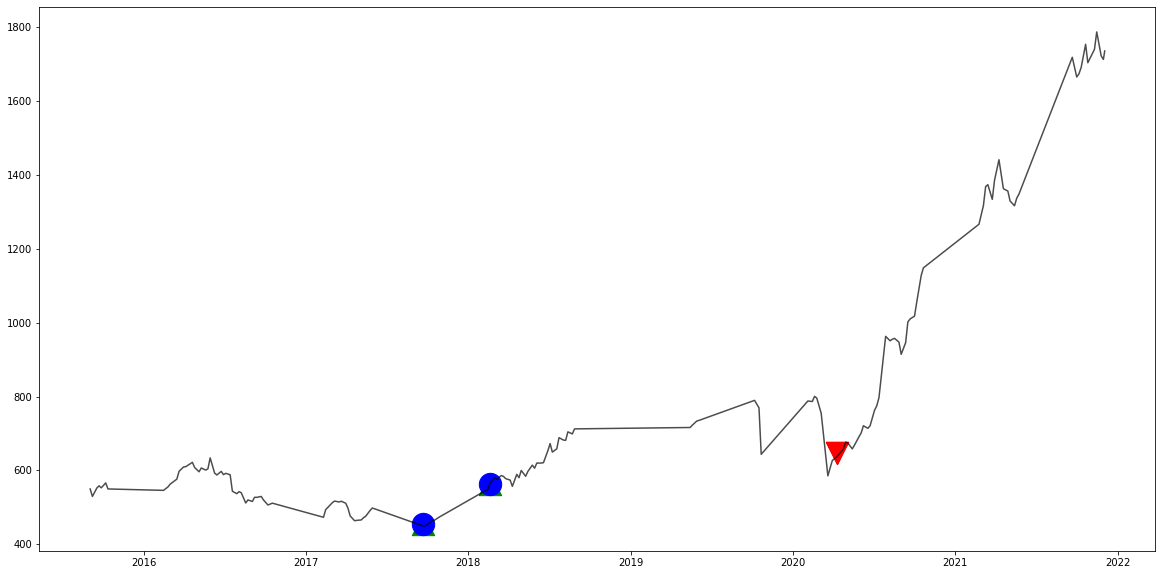

In [ ]:
plt.figure(figsize = (20,10))
plt.plot(df.Close,color = 'k',alpha=0.7)
plt.scatter(actual.buying_dates,df.Open[actual.buying_dates],marker='^',color = 'g',s= 500)
plt.scatter(actual.selling_dates,df.Open[actual.selling_dates],marker='v',color = 'r',s= 500)
plt.scatter(buying_dates,df.Open[buying_dates],marker='o',color = 'b',s= 500)

In [ ]:
df.to_csv('rel.csv')

In [ ]:
df['buy_minus_sell'] = df.Buy_cum - df.Sell

In [ ]:
df[(df.index >= '2020-03-05') & (df.rsi > 50)] #df.Buy_trigger==1) &

,Open,High,Low,Close,Adj Close,Volume,%K,%D,rsi,macd,Buy_trigger,Sell_trigger,Buy,Buy_cum,Sell,Sell_cum,buy_minus_sell
Date,,,,,,,,,,,,,,,,,
2020-04-23,273.500000,279.700012,268.500000,277.600006,275.668732,3594086,95.296740,82.122599,52.556111,6.338583,0,1,0,2,0,3,2
2020-04-29,274.000000,293.200012,272.700012,287.649994,285.648804,4058322,88.998975,83.258378,58.280508,5.369812,0,1,0,2,0,3,2
2020-04-30,295.049988,296.000000,285.100006,290.100006,288.081787,4675412,87.847593,86.192882,59.492670,5.639467,0,1,0,2,0,3,2
2020-05-07,271.200012,284.500000,268.450012,282.399994,280.435333,6505707,63.733317,35.688883,54.298271,2.569835,0,1,0,2,0,3,2
2020-05-08,285.100006,286.850006,280.549988,285.049988,283.066895,2594066,70.799967,55.199978,55.526851,2.877618,0,0,0,2,0,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-12,737.700012,755.500000,734.250000,750.299988,750.299988,4585484,81.931272,59.789153,54.738515,1.801038,0,0,0,2,0,4,2
2021-11-15,753.900024,756.500000,740.549988,749.799988,749.799988,2434426,88.695085,73.816878,54.534611,2.729201,0,0,0,2,0,4,2
2021-11-16,752.700012,761.700012,743.450012,746.450012,746.450012,3378779,81.067657,83.898005,53.107214,3.001424,0,0,0,2,0,4,2


In [ ]:
2017-05-31, 2019-05-22
2017-12-05, 2018-01-03, 2020-09-24

SyntaxError: ignored

In [ ]:
df[(df.Sell_cum <= df.Buy_cum) & (df.Sell  == 1) ]

,Open,High,Low,Close,Adj Close,Volume,%K,%D,rsi,macd,Buy_trigger,Sell_trigger,Buy,Sell,Buy_cum,Sell_cum,buy_minus_sell
Date,,,,,,,,,,,,,,,,,
2017-12-05,892.589172,912.104187,887.041748,905.120361,888.414124,8448505,38.108092,36.666276,49.451653,-4.125025,0,1,0,1,1,1,0
